In [1]:
import mesa
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
def compute_consensus(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    agreed_opinions = [i for i in agent_opinions if i >= 0.5]
    return len(agreed_opinions) / len(agent_opinions)

class Agent(mesa.Agent):
    
    def __init__(self, unique_id, model, w, alpha = 0.1):
        super().__init__(unique_id, model)
        # Initialise each agent with an opinion on whether H1 is true. Randomly distributed between 0 and 1.
        self.opinion = random.uniform(0,1)
#         self.opinion = 0.5
        # Weight is the same for each agent, since we are planning to use special case in SProdOp 
        self.weight = w
        self.alpha = alpha
        
    def pool_agents(self):
        # Want to return the self + n neighbouring agents.         
        neighbours = 0
        pooled_agents = [self]
        # Random approach - randomly choose n agents, assumes 'Well-mixed' model.
        while neighbours < self.model.pool_size:
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent not in pooled_agents:
                pooled_agents.append(other_agent)
                neighbours += 1
        return pooled_agents
    
    def SProdOp(self, pooled_agents): 
        # SProdOp from combining opinion pooling paper. Only works in special case when w = const.
        pooled_opinions = []
        for agent in pooled_agents:
            pooled_opinions.append(agent.opinion)
        w = self.weight
        c_x = ((np.prod(pooled_opinions))**w)/(((np.prod(pooled_opinions))**w)+(np.prod(list(1-np.asarray(pooled_opinions)))**w))
        for agent in pooled_agents:
            agent.opinion = c_x
            
    def bayesian_update(self):
        # Bayesian update according to Definition 3.1 from combining opinion pooling paper
        alpha = self.alpha
        op_val1 = self.opinion
        op_val2 = 1 - self.opinion
        self.opinion = ((1-alpha) * op_val1) / ((alpha * op_val2) + (1 - alpha) * (1 - op_val2))
        return self
        
    def step(self):
        # Simulate agents randomly coming comparing the two options
        x = random.uniform(0,1)
        if x < 0.2:
            self.bayesian_update()
            
        y = random.uniform(0,1)
        if y < 0.2:
            pooled_agents = self.pool_agents()
            self.SProdOp(pooled_agents)

        
        
class Model(mesa.Model):
    
    def __init__(self, K, n, w, alpha):
        self.num_agents = K
        self.schedule = mesa.time.RandomActivation(self)
        self.pool_size = n
        self.running = True
        
        for i in range(self.num_agents):
            a = Agent(i, self, w, alpha)
            self.schedule.add(a)
            
        self.datacollector = mesa.DataCollector(
            model_reporters = {"Consensus" : compute_consensus}, agent_reporters = {"Opinion" : "opinion"}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if compute_consensus(self) >= 1:
            self.running = False

Tests with no pooling, only Bayesian updating. Initialised with every agent starting with the opinion 0.5.

In [114]:
params = {"K": 100, "n": 3, "w": 0.1, "alpha": 0.1}

results = mesa.batch_run(
    Model,
    parameters=params,
    iterations=10,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
results_df = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.80it/s]


Text(0, 0.5, 'Opinion')

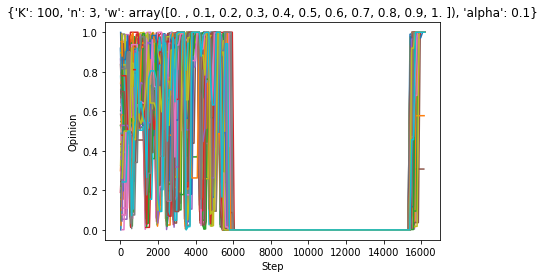

In [127]:
# Let's plot opinions. Say to get AgentID 0

plt.figure()
for agent in range(params["K"]):
    results_agent = results_df[(results_df.AgentID == agent) & (results_df.iteration == 0)]
    results_agent.Opinion.plot()
# plt.title("Agent opinions for \n $x_{i}$ = 0.5, $w_{i}$ = 0.9, $K = 10$, $n = 3$")
plt.title(params)
plt.xlabel("Step")
plt.ylabel("Opinion")
    
# Then you need to plot the opinion per


100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 21.99it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7efeb26790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7efeb26eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7efeb26400>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7efe8c2610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7efe8c29a0>,
 'means': []}

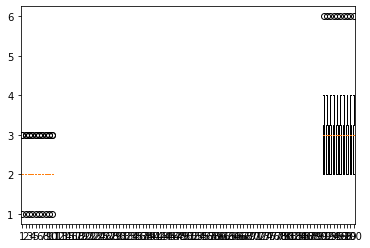

In [135]:
params = {"K": 100, "n": 3, "w": np.linspace(0,1,11), "alpha": 0.1}


results = mesa.batch_run(
    Model,
    parameters=params,
    iterations=10,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
results_df = pd.DataFrame(results)
data = []
plt.figure()
for w in np.linspace(0,1,10):
    unique_w_df = results_df[results_df.w == w]
    data2 = []
    for it in range(10):
        iterative_df = unique_w_df[(unique_w_df.iteration == it) & (unique_w_df.Consensus >= 0.9)]
        if len(iterative_df.Step) > 0:
            data2.append(iterative_df.Step.iloc[0])
        data.append(data2)
        
plt.boxplot(data)

Some issues/findings from this simulation:
- Some of the time it was converging to 0. Thought this was because of a bug but it was actually linked to the values of n and k. Experimented and found that it is due to the opinion pooling being overpowering and dragging the opinions down at a great rate, although you'd think there would be some sort of conservation? Anyway, changing is so that the opinions do not get pooled at every step, and making direct evidence collection more common, has now made the model converge every time.

This must be because the opinion pooling is pooling the opinion of h1 not being true. It likely comes from the random distribution of opinions at the beginning. So setting the opinion to be 0.5 at the start should stop this, which it does. 

In [113]:
ops = [0.24, 0.24, 0.24, 0.24, 0.24]
pooled_opinions = ops

w = 0.9

c_X = ((np.prod(pooled_opinions))**w)/(((np.prod(pooled_opinions))**w)+(np.prod(list(1-np.asarray(pooled_opinions)))**w))
c_X

0.005557368009678113

In [125]:
w = np.linspace(0,1,11)
w

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])